In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [4]:
def show_anns(anns, alpha=0.45):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [alpha]])
        img[m] = color_mask
    ax.imshow(img)

In [5]:
import matplotlib.patches as m_patches

def show_boxes(ax, boxes, edgecolor='r'):
    for box in boxes:
        rect = m_patches.Rectangle((box[0], box[1]),
                             box[2], 
                             box[3],
                             edgecolor=edgecolor, facecolor='none', linewidth=3)
        ax.add_patch(rect)

In [6]:
import random
import os
image_file = random.sample(os.listdir("_data/combined/test"), 1)[0]
image = cv2.imread(os.path.join("_data/combined/test", image_file))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

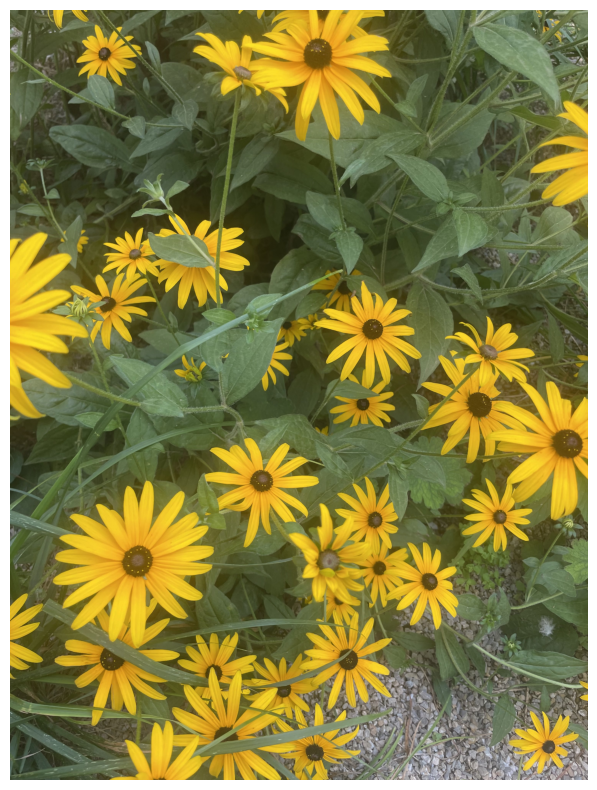

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [8]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.

OutOfMemoryError: CUDA out of memory. Tried to allocate 26.00 MiB. GPU 0 has a total capacity of 39.50 GiB of which 22.06 MiB is free. Process 2230512 has 38.02 GiB memory in use. Including non-PyTorch memory, this process has 1.44 GiB memory in use. Of the allocated memory 1.01 GiB is allocated by PyTorch, and 27.09 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
masks = mask_generator.generate(image)

In [ ]:
print(len(masks))
print(masks[0].keys())
print(masks[0]["segmentation"])
print(masks[0]["segmentation"].shape, image.shape)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [ ]:
fig, ax = plt.subplots()
ax.imshow(image)
show_boxes(ax, [mask["bbox"] for mask in masks])
plt.axis('off')
plt.show() 

In [ ]:
def get_patches(masks, image, apply_mask=False, padding=0):
    result = []
    
    for mask in masks:
        if apply_mask:
            image_tmp = image * (mask["segmentation"][:, :, np.newaxis])
        else:
            image_tmp = image
        
        bbox = mask["bbox"]
        x0 = bbox[1]-padding
        if x0 < 0:
            x0 = 0
        x1 = bbox[1]+bbox[3]+padding
        if x1 >= image.shape[0]:
            x1 = image.shape[0] - 1
        y0 = bbox[0]-padding
        if y0 < 0:
            y0 = 0
        y1 = bbox[0]+bbox[2]+padding
        if y1 >= image.shape[1]:
            y1 = image.shape[1] - 1
        
        patch = image_tmp[x0:x1, y0:y1]
        
        if 0 in patch.shape:
            continue
        result.append(patch)
    
    return result

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(get_patches(masks, image, True)[25])
plt.axis('off')
plt.show()

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class SingleClassDataset(Dataset):
    def __init__(self, folder_path, transform=None, apply_mask=False, crop_to_mask=False, split=1):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = [f for f in os.listdir(os.path.join(folder_path, "images")) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.apply_mask = apply_mask
        if apply_mask:
            self.mask_files = [f for f in os.listdir(os.path.join(folder_path, "leaf_instances")) if f.endswith(('.png', '.jpg', '.jpeg'))]
        if split < 1:
            self.image_files = self.image_files[:int(len(image_files) * split)]
            self.mask_files = self.mask_files[:int(len(mask_files) * split)]
        self.crop_to_mask = crop_to_mask

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.folder_path, "images", self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.apply_mask:
            mask_name = os.path.join(self.folder_path, "leaf_instances", self.mask_files[idx])
            mask = np.asarray(Image.open(mask_name).convert('L'))
            image = np.where(np.dstack([mask] * 3), image, 0)

            if self.crop_to_mask:
                binary_mask = np.any(image != [0, 0, 0], axis=-1)

                # Find the coordinates of the non-black pixels
                non_black_pixels = np.argwhere(binary_mask)

                # Find the bounding box of the non-black pixels
                top_left = np.min(non_black_pixels, axis=0)
                bottom_right = np.max(non_black_pixels, axis=0)
                
                image = image[top_left[0]:bottom_right[0]+1, top_left[1]:bottom_right[1]+1]
                
            image = Image.fromarray(image)
        
        
        if self.transform:
            image = self.transform(image)
        
        # Since it's a single class, we can use a constant label (e.g., 0)
        label = 0
        
        return image, label

# Usage example:
folder_path = '_data/urban_street0_25'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = SingleClassDataset(folder_path, transform=transform)

# Create a DataLoader
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
# Check if GPU is available
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# YOLO detection 

In [41]:
from ultralyticsplus import YOLO, render_result

# load model
model = YOLO('foduucom/plant-leaf-detection-and-classification')

# set model parameters
model.overrides['conf'] = 0.25  # NMS confidence threshold
model.overrides['iou'] = 0.45  # NMS IoU threshold
model.overrides['agnostic_nms'] = False  # NMS class-agnostic
model.overrides['max_det'] = 1000  # maximum number of detections per image

# perform inference
results = model.predict(os.path.realpath(os.path.join("_data", "combined", "test", image_file)))

# observe results
print(results[0].boxes)


image 1/1 /home/stefan.steinheber/bachelor/processing/leaf_segmentation/_data/combined/test/test3.jpg: 640x480 5 Blueberrys, 2 gauavas, 1 apple, 6.7ms
Speed: 2.4ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([22., 14., 14., 14., 22., 14., 28., 14.], device='cuda:0')
conf: tensor([0.6934, 0.5878, 0.5857, 0.5853, 0.5585, 0.4639, 0.2858, 0.2625], device='cuda:0')
data: tensor([[1.4180e+03, 2.1964e+03, 2.0904e+03, 3.2700e+03, 6.9341e-01, 2.2000e+01],
        [1.7065e+02, 1.2007e+03, 1.1361e+03, 1.7391e+03, 5.8779e-01, 1.4000e+01],
        [2.0058e+03, 3.3516e+01, 3.0240e+03, 4.8999e+02, 5.8566e-01, 1.4000e+01],
        [9.0139e+02, 7.6179e+02, 1.4239e+03, 1.1691e+03, 5.8530e-01, 1.4000e+01],
        [8.6794e+02, 2.4297e+03, 1.3416e+03, 2.9094e+03, 5.5847e-01, 2.2000e+01],
        [1.7341e+03, 4.2468e+02, 2.4014e+03, 1.1854e+03, 4.6386e-01, 1.4000e+01],
        [1.8935e+03, 1.1829e+

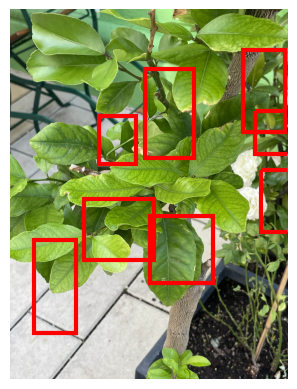

In [42]:
import matplotlib.patches as patches

fig, ax = plt.subplots()
ax.imshow(image)
results = results[0].cpu()
for i in range(len(results)):
    rect = patches.Rectangle((results.boxes.xywh[i, 1], results.boxes.xywh[i, 0]),
                             results.boxes.xywh[i, 3], 
                             results.boxes.xywh[i, 2],
                             edgecolor='r', facecolor='none', linewidth=3)
    ax.add_patch(rect)
plt.axis('off')
plt.show() 

# SAM + YOLO detection

In [ ]:
from ultralyticsplus import YOLO, render_result

# load model
model = YOLO('foduucom/plant-leaf-detection-and-classification')

# set model parameters
model.overrides['conf'] = 0.8  # NMS confidence threshold
model.overrides['iou'] = 0.45  # NMS IoU threshold
model.overrides['agnostic_nms'] = False  # NMS class-agnostic
model.overrides['max_det'] = 1000  # maximum number of detections per image

patches = get_patches(masks, image, apply_mask=True)
results = []

for patch in patches:
    # perform inference
    result = model.predict(patch)
    results.append(result[0])

In [47]:
print(len([result for result in results if len(result.boxes) > 0]))

134


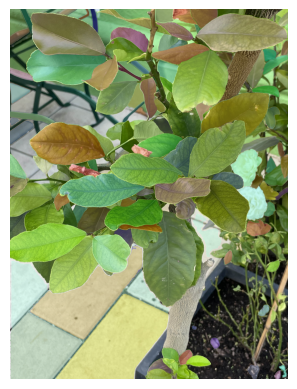

In [48]:
import matplotlib.patches as patches
fig, ax = plt.subplots()
ax.imshow(image)


leaf_masks = [mask for mask, result in zip(masks, results) if len(result.boxes) > 0]

show_anns(leaf_masks)
plt.axis('off')
plt.show() 

# ResNet classification

In [81]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50, ResNet50_Weights

In [82]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [83]:
class BinaryResnetClassifier(nn.Module):
    def __init__(self, num_classes=1):
        super(BinaryResnetClassifier, self).__init__()
        # Load a pre-trained ResNet model
        self.resnet = resnet50(ResNet50_Weights.IMAGENET1K_V1)  # You can choose any ResNet variant
        # Modify the last fully connected layer
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
        nn.init.xavier_normal_(self.resnet.fc.weight)
        
    def forward(self, x):
        # Pass the input through the ResNet
        x = self.resnet(x)
        # Apply the sigmoid activation function
#        x = torch.sigmoid(x)  # Output will be between 0 and 1
        return x

In [84]:
resnet = BinaryResnetClassifier()
resnet = resnet.to(device)

/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [85]:
from torchsummary import summary
#summary(resnet, (3, 256, 256))

In [115]:
import torchvision.transforms.v2 as transforms

tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.RandomAffine(180, shear=45),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])

/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [116]:
dataset = ImageFolder("_data/bi_class/places", transform=tf)
dataloader = DataLoader(dataset, 
                        batch_size=32, 
                        shuffle=True, 
                        num_workers=12, 
                        drop_last=True, 
                        pin_memory=True)

/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9776908].


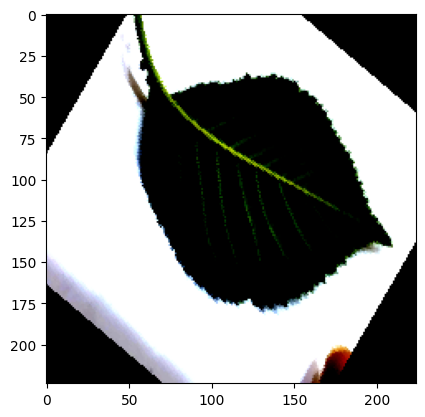

0


In [118]:
batch = next(iter(dataloader))
plt.imshow(batch[0][0].permute((1,2,0)))
plt.show()
print(batch[1][0].item())

In [119]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(resnet.parameters(), lr=1e-3)

In [120]:
import pandas as pd
df_training = pd.DataFrame(columns=["loss", "accuracy", "precision", "recall", "f1_score"])

In [121]:
import one_class_detection
print("Starting Training")
#resnet = torch.load("out/resnet_latest.pth")
#resnet = resnet.to(device)
num_epochs = 20
for epoch in range(num_epochs):
    data_iter = iter(dataloader)

    next_batch = next(data_iter) # start loading the first batch
    next_batch = [ _.cuda(non_blocking=True) for _ in next_batch ]  # with pin_memory=True and non_blocking=True, this will copy data to GPU non blockingly

    for i in range(len(dataloader)):
        batch = next_batch 
        if i + 2 != len(dataloader): 
            # start copying data of next batch
            next_batch = next(data_iter)
            next_batch = [ _.cuda(non_blocking=True) for _ in next_batch]

        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        pred = resnet(inputs)
        label = labels.unsqueeze(1).to(dtype=torch.float32)
        #print(pred, label)
        loss = criterion(pred, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.9f}')
    torch.save(resnet, "out/leaf_classifier/resnet/resnet_latest.pth")
    
    def predict_resnet(batch_input):
        batch_input = batch_input.to(device)
        output = resnet(batch_input)
        result = (output >= .5).float()
        return result.cpu()

    test_results = one_class_detection.test_loop(predict_resnet)
    
    df_training.loc[len(df_training.index)] = [loss.item()] + list(test_results.values())
    df_training.to_csv("out/leaf_classifier/resnet/training_metrics.csv")

Starting Training


/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/20], Loss: 0.030749455


/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [2/20], Loss: 0.052259754


/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [3/20], Loss: 0.000063098


/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [4/20], Loss: 0.000411569


/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [5/20], Loss: 0.021181863


/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [6/20], Loss: 0.000919123


/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [7/20], Loss: 0.003837972


/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [8/20], Loss: 0.000087602


/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [9/20], Loss: 0.003134283


/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [10/20], Loss: 0.002550791


/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [11/20], Loss: 0.000140247


/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [12/20], Loss: 0.000749797


/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [13/20], Loss: 0.002781800


/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [14/20], Loss: 0.000639958


/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [15/20], Loss: 0.000084951


/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [16/20], Loss: 0.059893906


/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [17/20], Loss: 0.000595549


/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [18/20], Loss: 0.000108291


/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [19/20], Loss: 0.000092205


/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [20/20], Loss: 0.000250524


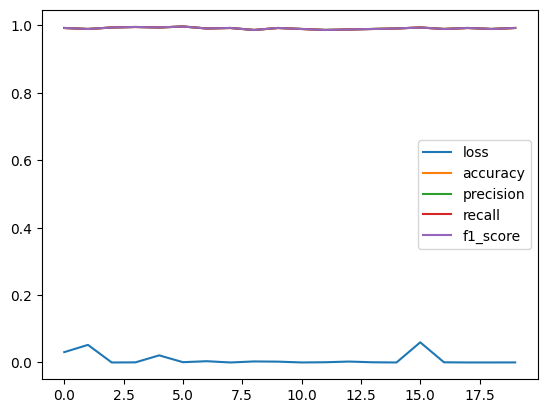

In [122]:
import matplotlib.pyplot as plt
df_training = pd.read_csv("out/leaf_classifier/resnet/training_metrics.csv")
df_training = df_training.drop(df_training.columns[0], axis="columns")

for col in df_training.columns:
    plt.plot(df_training.index, df_training[col], label=col)
    
plt.legend()
plt.show()

In [123]:
import one_class_detection
import importlib
importlib.reload(one_class_detection)

resnet = torch.load("out/leaf_classifier/resnet/resnet_latest.pth")
resnet = resnet.to(device)

def predict_resnet(batch_input):
    batch_input = batch_input.to(device)
    output = resnet(batch_input)
    result = (output >= .5).float()
    return result.cpu()

one_class_detection.test_loop(predict_resnet)

/tmp/ipykernel_1014013/3522833044.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet = torch.load("out/leaf_classifier/resnet/resnet_latest.pth")


{'accuracy': 0.9895833333333334,
 'precision': 0.9898016467065868,
 'recall': 0.9895833333333334,
 'f1_score': 0.9895851099647148}

In [158]:
patches = get_patches(masks, image, padding=65)

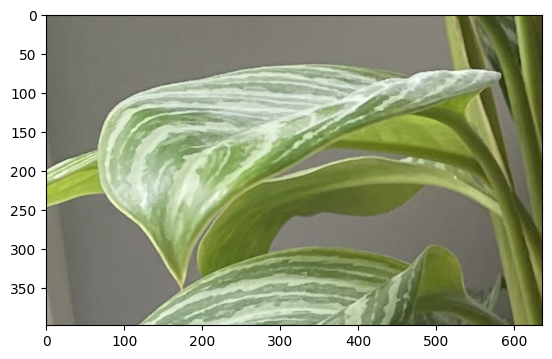

In [163]:
plt.imshow(patches[12])
plt.show()

In [166]:
resnet(tf(patches[12]).to(device).unsqueeze(0)).item()

-5.30206823348999

In [58]:
from PIL import Image
results = []
with torch.no_grad():
    for patch in patches:
        input = tf(Image.fromarray(patch)).unsqueeze(0).to(device)
        result = torch.sigmoid(resnet(input)).cpu().item()
        
        results.append(result)

In [59]:
print(results)
print(np.min(results), np.max(results))

[0.004620015621185303, 0.022899674251675606, 0.12162532657384872, 0.4775432050228119, 0.15344996750354767, 0.014606325887143612, 0.013772139325737953, 0.00835163053125143, 0.04876173287630081, 0.03549957647919655, 0.0031797708943486214, 0.025390377268195152, 0.007675631437450647, 0.006295105442404747, 0.2270183563232422, 0.0013700624695047736, 0.05938396975398064, 0.007000562734901905, 0.004788372199982405, 0.06475692242383957, 0.004090883769094944, 0.5396196246147156, 0.0427037812769413, 0.06755699217319489, 0.08835947513580322, 0.06748960167169571, 0.20867620408535004, 0.08047949522733688, 0.003069628030061722, 0.04244617372751236, 0.025428814813494682, 0.027101337909698486, 0.031582921743392944, 0.007114584092050791, 0.013400292955338955, 0.29348865151405334, 0.006760475225746632, 0.04355120658874512, 0.17686285078525543, 0.01909237541258335, 0.21959573030471802, 0.4471075236797333, 0.07380113750696182, 0.3588520288467407, 0.25554588437080383, 0.025542156770825386, 0.222844958305358

Detected leaf masks: 85


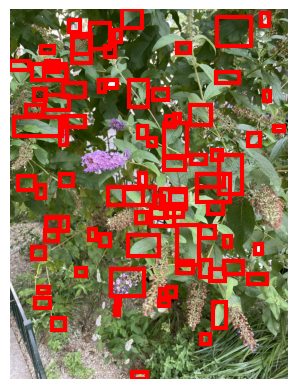

In [64]:
import matplotlib.patches as patches

PROBABILITY_THRESHOLD = .1
masks_filtered = [mask for mask, result in zip(masks,results) if result > PROBABILITY_THRESHOLD]
print("Detected leaf masks:", len(masks_filtered))
fig, ax = plt.subplots()
ax.imshow(image)
show_boxes(ax, [mask["bbox"] for mask in masks_filtered])
plt.axis('off')
plt.show() 

# Isolation forest detection

In [17]:
import torch
from torch.utils.data import DataLoader
from pyod.models.iforest import IForest
import numpy as np

# Initialize and fit the Isolation Forest model
clf = IForest(contamination=0.1)  # Adjust contamination as needed
clf.fit(dataset)

# Get the outlier scores
outlier_scores = clf.decision_function(X)

# Get binary labels (0 for inliers, 1 for outliers)
outlier_labels = clf.predict(X)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (3261, 2) + inhomogeneous part.

# Autoencoder leaf-detection

## Training

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

In [16]:
class Encoder(nn.Module):
    def __init__(self, in_channels=3, out_channels=16, latent_dim=200, act_fn=nn.ReLU()):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, stride=2),  # 112x112
            act_fn,
            nn.Conv2d(out_channels, 2*out_channels, 3, padding=1, stride=2),  # 56x56
            act_fn,
            nn.Conv2d(2*out_channels, 4*out_channels, 3, padding=1, stride=2),  # 28x28
            act_fn,
            nn.Conv2d(4*out_channels, 8*out_channels, 3, padding=1, stride=2),  # 14x14
            act_fn,
            nn.Conv2d(8*out_channels, 16*out_channels, 3, padding=1, stride=2),  # 7x7
            act_fn,
            nn.Flatten(),
            nn.Linear(16*out_channels*7*7, latent_dim),
            act_fn
        )

    def forward(self, x):
        return self.net(x)

class Decoder(nn.Module):
    def __init__(self, in_channels=3, out_channels=16, latent_dim=200, act_fn=nn.ReLU()):
        super().__init__()
        self.out_channels = out_channels
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 16*out_channels*7*7),
            act_fn
        )
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(16*out_channels, 8*out_channels, 3, stride=2, padding=1, output_padding=1),  # 14x14
            act_fn,
            nn.ConvTranspose2d(8*out_channels, 4*out_channels, 3, stride=2, padding=1, output_padding=1),  # 28x28
            act_fn,
            nn.ConvTranspose2d(4*out_channels, 2*out_channels, 3, stride=2, padding=1, output_padding=1),  # 56x56
            act_fn,
            nn.ConvTranspose2d(2*out_channels, out_channels, 3, stride=2, padding=1, output_padding=1),  # 112x112
            act_fn,
            nn.ConvTranspose2d(out_channels, in_channels, 3, stride=2, padding=1, output_padding=1),  # 224x224
        )

    def forward(self, x):
        output = self.linear(x)
        output = output.view(-1, 16*self.out_channels, 7, 7)
        output = self.conv(output)
        return output

#  defining autoencoder
class BigAutoencoder(nn.Module):
    def __init__(self, encoder=Encoder(), decoder=Decoder()):
        super().__init__()
        self.encoder = encoder
#        self.encoder.to(device)

        self.decoder = decoder
#        self.decoder.to(device)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [17]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])

dataset = SingleClassDataset('_data/us_leaf_d', transform=transform, apply_mask=True, crop_to_mask=True, split=.8)
dataset_val = SingleClassDataset('_data/us_leaf_d', transform=transform, apply_mask=True, crop_to_mask=True, split=-.2)
dataloader = DataLoader(dataset, batch_size=20, shuffle=True, num_workers=2, pin_memory=True)
dataloader_val = DataLoader(dataset_val, batch_size=20, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2885156].


torch.Size([224, 224, 3])


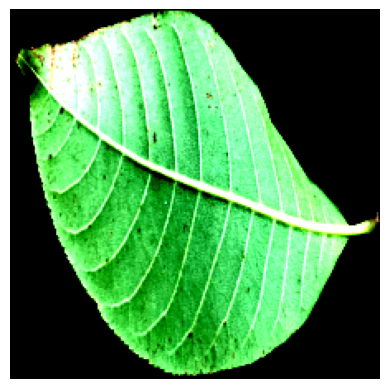

In [18]:
import matplotlib.pyplot as plt
sample, _ = next(iter(dataloader))
sample = torch.permute(sample[0], (1, 2, 0))
print(sample.shape)
plt.imshow(sample)
plt.axis('off')
plt.show()

In [19]:
def masked_mse_loss(output, target):
    mask = target == 0
    output[mask] = 0
    return nn.MSELoss()(output, target)

In [20]:
model = BigAutoencoder()
#model = torch.load("out/autoencoder_latest.pth")
criterion = masked_mse_loss
optimizer = optim.Adam(model.parameters(), lr=1e-3)

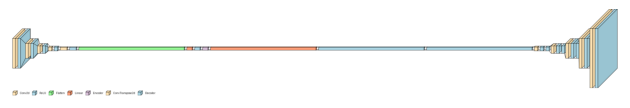

<Figure size 640x480 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt

import visualtorch
img = visualtorch.layered_view(model.to('cpu'), input_shape=(1, 3, 224, 224), legend=True)

plt.axis("off")
plt.tight_layout()
plt.imshow(img)
plt.show()

plt.savefig("out/leaf_classifier/autoencoder/structure.png")

In [21]:
model = model.to(device)

In [22]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             448
              ReLU-2         [-1, 16, 112, 112]               0
            Conv2d-3           [-1, 32, 56, 56]           4,640
              ReLU-4           [-1, 32, 56, 56]               0
            Conv2d-5           [-1, 64, 28, 28]          18,496
              ReLU-6           [-1, 64, 28, 28]               0
            Conv2d-7          [-1, 128, 14, 14]          73,856
              ReLU-8          [-1, 128, 14, 14]               0
            Conv2d-9            [-1, 256, 7, 7]         295,168
             ReLU-10            [-1, 256, 7, 7]               0
          Flatten-11                [-1, 12544]               0
           Linear-12                  [-1, 200]       2,509,000
             ReLU-13                  [-1, 200]               0
          Encoder-14                  [

In [32]:
import pandas as pd
df_training = pd.DataFrame(columns=["loss", "accuracy", "precision", "recall", "f1_score"])

In [33]:
print(df_training.columns)

Index(['loss', 'accuracy', 'precision', 'recall', 'f1_score'], dtype='object')


In [34]:
if os.path.exists("out/leaf_classifier/autoencoder_masked_loss/training_metrics.csv"):
    df_training = pd.read_csv("out/leaf_classifier/autoencoder_masked_loss/training_metrics.csv")
if os.path.exists("out/leaf_classifier/autoencoder_masked_loss/autoencoder_latest.pth"):
    model = torch.load("out/leaf_classifier/autoencoder_masked_loss/autoencoder_latest.pth")

In [35]:
print(df_training.columns)

Index(['loss', 'accuracy', 'precision', 'recall', 'f1_score'], dtype='object')


In [ ]:
import one_class_detection
from tqdm import tqdm

print("Starting Training")
num_epochs = 50
for epoch in range(num_epochs):
    data_iter = iter(dataloader)

    next_batch = next(data_iter) # start loading the first batch
    next_batch = [ _.cuda(non_blocking=True) for _ in next_batch ] 
    # with pin_memory=True and non_blocking=True, this will copy data to GPU non blockingly

    epoch_loss = 0
    epoch_length = 0
    
    p_bar = tqdm(range(len(dataloader)))
    for i in p_bar:
        batch = next_batch 
        if i + 2 != len(dataloader): 
            # start copying data of next batch
            next_batch = next(data_iter)
            next_batch = [ _.cuda(non_blocking=True) for _ in next_batch]

        # training code
        #batch = [data for data, _ in batch]
        
        recon = model(batch[0])
        loss = criterion(recon, batch[0])
        p_bar.set_description(f"Loss: {loss}")
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += recon.shape[0] * loss.item()
        epoch_length += recon.shape[0]

    epoch_loss = epoch_loss / epoch_length
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.9f}')
    torch.save(model, "out/leaf_classifier/autoencoder_masked_loss/autoencoder_latest.pth")
    
    ae = one_class_detection.Autoencoder(model)
    test_result = ae.test()
    df_training = pd.concat([df_training, 
                             pd.DataFrame([[epoch_loss] + list(test_result.values())], 
                                          columns=df_training.columns)])
    df_training.to_csv("out/leaf_classifier/autoencoder_masked_loss/training_metrics.csv")

Starting Training


Loss: 0.17451085150241852: 100%|██████████| 489/489 [08:28<00:00,  1.04s/it]


Epoch [1/50], Loss: 0.228401514


/tmp/ipykernel_2093842/354201983.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_training = pd.concat([df_training,
Loss: 0.19497166574001312: 100%|██████████| 489/489 [08:20<00:00,  1.02s/it]


Epoch [2/50], Loss: 0.191667465


Loss: 0.15617892146110535: 100%|██████████| 489/489 [08:12<00:00,  1.01s/it]


Epoch [3/50], Loss: 0.174490162


Loss: 0.14955832064151764: 100%|██████████| 489/489 [08:19<00:00,  1.02s/it]


Epoch [4/50], Loss: 0.164034382


Loss: 0.17943955957889557: 100%|██████████| 489/489 [08:25<00:00,  1.03s/it]


Epoch [5/50], Loss: 0.156622032


Loss: 0.11849559843540192: 100%|██████████| 489/489 [08:19<00:00,  1.02s/it]


Epoch [6/50], Loss: 0.149902308


Loss: 0.12517546117305756: 100%|██████████| 489/489 [08:18<00:00,  1.02s/it]


Epoch [7/50], Loss: 0.140118647


Loss: 0.08837299793958664: 100%|██████████| 489/489 [09:42<00:00,  1.19s/it]


Epoch [8/50], Loss: 0.132923449


Loss: 0.10334157198667526: 100%|██████████| 489/489 [08:20<00:00,  1.02s/it]


Epoch [9/50], Loss: 0.123529728


Loss: 0.10561193525791168:  85%|████████▌ | 416/489 [07:07<01:10,  1.03it/s]

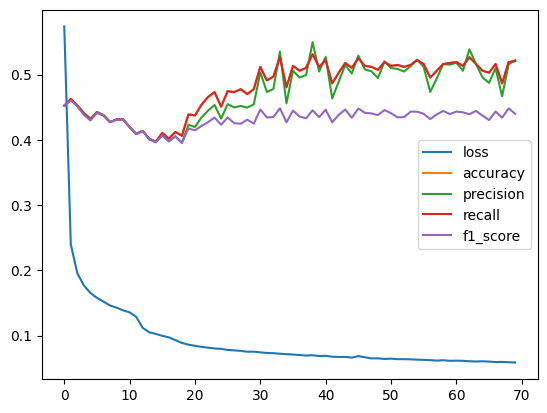

In [28]:
import matplotlib.pyplot as plt
df_training = pd.read_csv("out/leaf_classifier/autoencoder/training_metrics.csv")
df_training = df_training.drop(df_training.columns[0], axis="columns")

for col in df_training.columns:
    plt.plot(df_training.index, df_training[col], label=col)
    
plt.legend()
plt.show()

## Testing the trained model

In [23]:
import one_class_detection
import importlib
importlib.reload(one_class_detection)
ae = one_class_detection.Autoencoder(model)
ae.test()

{'accuracy': 0.7083333333333334,
 'precision': 0.7303975200583515,
 'recall': 0.7083333333333334,
 'f1_score': 0.6985788649345863}

In [35]:
# Function to compute anomaly score
def anomaly_score(img):
    model.eval()
    with torch.no_grad():
        img = img.to(device)  # Move input to GPU
        recon = model(img.unsqueeze(0))
        return nn.MSELoss()(recon, img.unsqueeze(0)).item()

In [36]:
# Example usage
from PIL import Image

test_tensor = transform(Image.fromarray(image)).to(device)  # Move test tensor to GPU
score = anomaly_score(test_tensor)
print(f'Anomaly score: {score}')

Anomaly score: 0.03849826008081436


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.030659005..0.80810165].


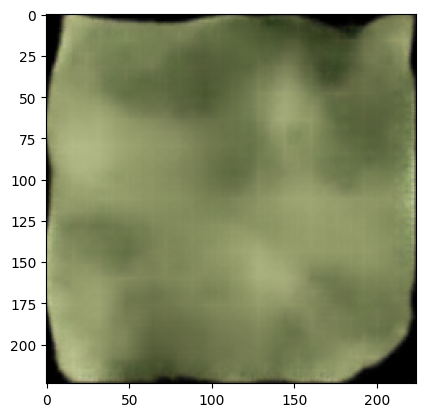

In [37]:
model.eval()
with torch.no_grad():
    recon = model(transform(Image.fromarray(image)).unsqueeze(0).to(device))
    plt.imshow(recon.cpu().numpy().squeeze().transpose((1, 2, 0)))
    plt.show()

## Inference 

In [9]:
#model = torch.load("out/autoencoder_model.pth")
model = torch.load("out/leaf_classifier/autoencoder/autoencoder_latest.pth")
model.to(device)

/tmp/ipykernel_478319/2304852818.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("out/autoencoder_latest.pth")


BigAutoencoder(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): ReLU()
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (9): ReLU()
      (10): Flatten(start_dim=1, end_dim=-1)
      (11): Linear(in_features=12544, out_features=200, bias=True)
      (12): ReLU()
    )
  )
  (decoder): Decoder(
    (linear): Sequential(
      (0): Linear(in_features=200, out_features=12544, bias=True)
      (1): ReLU()
    )
    (conv): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(128

In [52]:
model.eval()
patches = get_patches(masks, image, True)
results = []
with torch.no_grad():
    for patch in patches:
        #result = model(transform(Image.fromarray(patch)).unsqueeze(0).to(device))
        results.append(anomaly_score(transform(Image.fromarray(patch))))

In [53]:
print(results)

[0.010771065950393677, 0.01487906463444233, 0.02022959105670452, 0.014664539135992527, 0.018378950655460358, 0.022761110216379166, 0.011428783647716045, 0.04956831783056259, 0.012767584063112736, 0.017550144344568253, 0.0053255874663591385, 0.015174182131886482, 0.006195089779794216, 0.021010883152484894, 0.018161237239837646, 0.003024713834747672, 0.004100357182323933, 0.015490272082388401, 0.008744707331061363, 0.021372539922595024, 0.009000622667372227, 0.007966321893036366, 0.007850716821849346, 0.0029691513627767563, 0.010075528174638748, 0.007056227419525385, 0.010519761592149734, 0.011137392371892929, 0.016243888065218925, 0.008916210383176804, 0.017665209248661995, 0.006666841916739941, 0.006141393445432186, 0.011291373521089554, 0.0056091188453137875, 0.003880304517224431, 0.004439832642674446, 0.016750449314713478, 0.0035008492413908243, 0.006945065688341856, 0.002668553963303566, 0.005450604949146509, 0.02132156863808632, 0.003985960967838764, 0.004843323025852442, 0.0023739

Detected leaf masks: 44


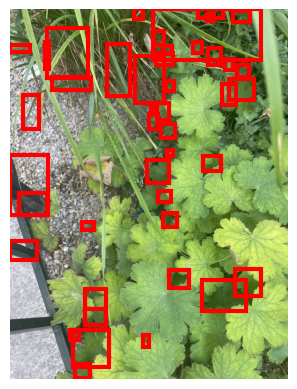

In [54]:
import matplotlib.patches as patches

ANOMALY_THRESHOLD = 0.004
masks_filtered = [mask for mask, result in zip(masks,results) if result < ANOMALY_THRESHOLD]
print("Detected leaf masks:", len(masks_filtered))
fig, ax = plt.subplots()
ax.imshow(image)
show_boxes(ax, [mask["bbox"] for mask in masks_filtered])
plt.axis('off')
plt.show() 

# Comparing Resnet to Autoencoder

In [29]:
import torch
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.v2 as transforms

In [33]:
resnet = torch.load("out/leaf_classifier/resnet/resnet_latest.pth")
autoencoder = torch.load("out/leaf_classifier/autoencoder/autoencoder_latest.pth")

/tmp/ipykernel_1014013/2006269752.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet = torch.load("out/leaf_classifier/resnet/resnet_latest.pth")
/tmp/ipykernel_1014

In [176]:
patches = get_patches(masks, image)

In [177]:
# Function to compute anomaly score
def anomaly_score(model, img):
    model.eval()
    with torch.no_grad():
        img = img.to(device)  # Move input to GPU
        recon = model(img.unsqueeze(0))
        mse = nn.MSELoss()(recon, img.unsqueeze(0))
        return torch.sigmoid(mse).item()

In [178]:
transform_autoencoder = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])

/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [179]:
results_autoencoder = []
with torch.no_grad():
    for patch in patches:
        results_autoencoder.append(anomaly_score(resnet, transform_autoencoder(Image.fromarray(patch))))

/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1, 3, 224, 224])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [180]:
transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),  
])

/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [181]:
results_resnet = []
with torch.no_grad():
    for patch in patches:
        input = transform_resnet(Image.fromarray(patch)).unsqueeze(0).to(device)
        result = torch.sigmoid(resnet(input)).cpu().item()
        
        results_resnet.append(result)

In [182]:
print(min(results_resnet), max(results_resnet))
print(results_resnet)

8.617632762050681e-19 1.0
[0.9994587302207947, 1.0, 2.4108892375807045e-06, 0.9998961687088013, 0.9109720587730408, 0.0018964532064273953, 0.0004250251513440162, 0.9940158128738403, 8.617632762050681e-19, 0.999998927116394, 0.9977472424507141, 0.9859835505485535, 0.999994158744812, 0.9998687505722046, 0.9999963045120239, 0.012672065757215023, 0.9738150238990784, 0.9939044117927551, 0.8695278167724609, 0.994005024433136, 0.9999995231628418, 1.0, 0.9990550875663757, 0.9973844885826111, 0.9986187219619751, 0.6379684805870056, 1.0, 0.9999998807907104, 0.8413133025169373, 0.9999995231628418, 0.8402429819107056, 0.9999998807907104, 0.033957045525312424, 0.9999998807907104, 0.9995176792144775, 0.9999996423721313, 0.9468242526054382, 0.24809494614601135, 0.7826216816902161, 2.051254721635587e-09, 0.9998517036437988, 0.9999995231628418, 0.9999997615814209, 0.9999994039535522, 0.9984330534934998, 0.6328079104423523, 0.9999998807907104, 0.8132676482200623, 0.9999998807907104, 1.0, 0.9999997615814

In [183]:
print(min(results_autoencoder), max(results_autoencoder))
print(results_autoencoder)

0.5151147246360779 1.0
[1.0, 1.0, 1.0, 1.0, 0.5502293705940247, 0.9987549781799316, 0.8216783404350281, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9760361313819885, 1.0, 1.0, 0.5818299651145935, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9997310042381287, 1.0, 1.0, 1.0, 1.0, 0.9999986886978149, 1.0, 0.9998791217803955, 1.0, 0.9999998807907104, 1.0, 1.0, 1.0, 0.5151147246360779, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7142824530601501, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7052209973335266, 0.9999955892562866, 1.0, 1.0, 1.0, 1.0, 0.9867807030677795, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995217323303223, 0.9999986886978149, 1.0, 1.0, 1.0, 1.0, 0.9998210072517395, 1.0, 1.0, 0.9072073698043823, 1.0, 1.0, 1.0, 0.595706045627594, 1.0, 1.0, 1.0, 0.9997034668922424, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6654278039932251, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9803300499916077, 1.0, 1.0, 1.

In [184]:
AUTOENCODER_THRESHOLD = .75
RESNET_THRESHOLD = .01

In [ ]:
masks_autoencoder = [mask for mask, result in zip(masks,results_autoencoder) 
                     if result > AUTOENCODER_THRESHOLD]

masks_resnet = [mask for mask, result in zip(masks,results_resnet) 
                     if result < RESNET_THRESHOLD]
print(f"Detected leaf masks: AE {len(masks_autoencoder)}, RN: {len(masks_resnet)}")

fig, ax = plt.subplots()
ax.imshow(image)
show_boxes(ax, [mask["bbox"] for mask in masks_autoencoder], '#0000ff89')
show_boxes(ax, [mask["bbox"] for mask in masks_resnet], '#ff000089')
plt.axis('off')
plt.show() 

#Detections Resnet: 10
#Detections Autoencoder: 7


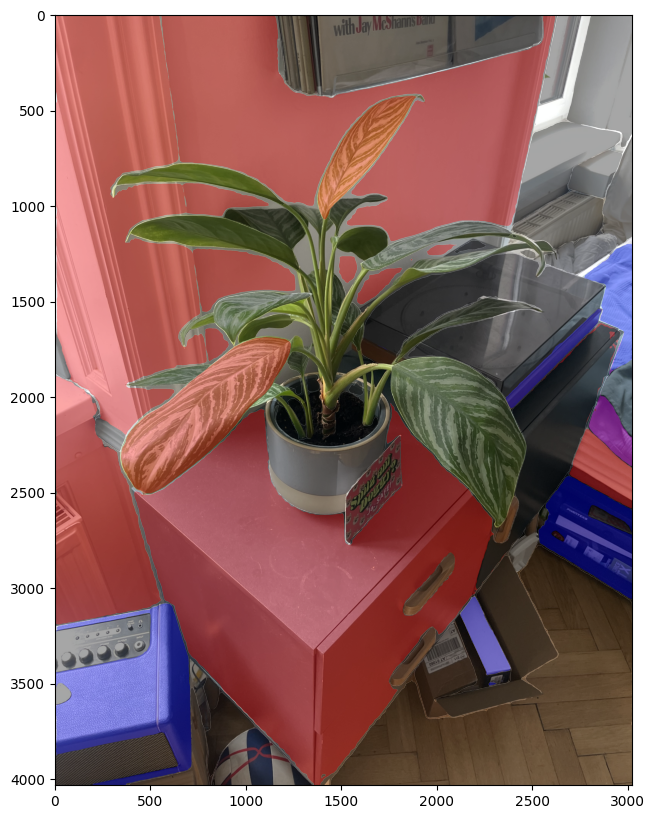

In [187]:
plt.figure(figsize=(10,10))
plt.imshow(image)
ax = plt.gca()
ax.set_autoscale_on(False)

img = np.ones((image.shape[0], image.shape[1], 4))
img[:,:,3] = 0

num_resnet = 0
num_autoencoder = 0

for ann, result_resnet, result_autoencoder in zip(masks, results_resnet, results_autoencoder):
    resnet_part = np.array([1, 0, 0]) if result_resnet < RESNET_THRESHOLD else np.array([0, 0, 0])
    autoencoder_part = np.array([0, 0, 1]) if result_autoencoder < AUTOENCODER_THRESHOLD else np.array([0, 0, 0])
    num_resnet += resnet_part[0]
    num_autoencoder += autoencoder_part[2]
    color = resnet_part + autoencoder_part
    m = ann['segmentation']
    color_mask = np.concatenate([color, [0.35]])
    img[m] = color_mask

print(f"#Detections Resnet: {num_resnet} (RED)")
print(f"#Detections Autoencoder: {num_autoencoder} (BLUE)")
    
ax.imshow(img)
plt.show()

# YOLOv8 prediction

In [15]:
from ultralytics import YOLO, checks
import cv2

In [16]:
checks()

Ultralytics 8.3.17 🚀 Python-3.12.4 torch-2.5.0.dev20240716 CUDA:0 (NVIDIA A100-SXM4-40GB, 40444MiB)
Setup complete ✅ (256 CPUs, 2015.2 GB RAM, 48.5/445.3 GB disk)


In [34]:
patches = get_patches(masks, image)
model = YOLO("out/yolo_urban_street/train/weights/best.pt")
model.info()
results_yolo = []
for patch in patches:
    result = model.predict(patch)
    results_yolo.append(1 if result[0].masks is not None and len(result[0].masks) > 0 else 0)

YOLOv8m-seg summary: 355 layers, 24,605,027 parameters, 0 gradients, 99.2 GFLOPs

0: 640x640 1 leaf, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x576 1 leaf, 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 576)

0: 640x576 1 leaf, 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)

0: 640x544 1 leaf, 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)

0: 640x320 1 leaf, 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

0: 576x640 1 leaf, 8.6ms
Speed: 2.1ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 640)

0: 640x512 1 leaf, 8.1ms
Speed: 2.1ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)

0: 640x224 (no detections), 8.2ms
Speed: 1.6ms preprocess, 8.2ms

Detected leaf masks: 118


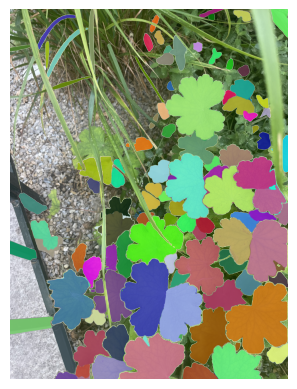

In [32]:
import matplotlib.patches as patches

ANOMALY_THRESHOLD = 0.004
masks_filtered = [mask for mask, result in zip(masks,results_yolo) if result > 0]
print("Detected leaf masks:", len(masks_filtered))
fig, ax = plt.subplots()
ax.imshow(image)
show_anns(masks_filtered, .85)
plt.axis('off')
plt.show() 

# CLIP (HF)

In [2]:
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

inputs = []
for patch in patches:
    inputs.append(Image.fromarray(patch))


inputs = processor(text=["a photo leaf", "a photo of a non-leaf"], images=image, return_tensors="pt", padding=True)
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]


NameError: name 'patches' is not defined